# Gaussian Processes

## Introduction

[Gaussian Processes](https://en.wikipedia.org/wiki/Gaussian_process) have been used in supervised, unsupervised, and even reinforcement learning problems and are described by an elegant mathematical theory (for an overview of the subject see [1, 4]). They are also very attractive conceptually, since they offer an intuitive way to define priors over functions. And finally, since Gaussian Processes are formulated in a Bayesian setting, they come equipped with a powerful notion of uncertainty. 

Happily, Pyro offers some support for Gaussian Processes in the `pyro.contrib.gp` module. The goal of this tutorial is to give a brief introduction to Gaussian Processes (GPs) in the context of this module. We will mostly be focusing on how to use the GP interface in Pyro and refer the reader to the references for more details about GPs in general.

The model we're interested in is defined by
$$f \sim \mathcal{GP}\left(0, \mathbf{K}_f(x, x')\right)$$

and
$$y = f(x) + \epsilon,\quad \epsilon \sim \mathcal{N}\left(0, \beta^{-1}\mathbf{I}\right).$$

Here $x, x' \in\mathbf{X}$ are points in the input space and $y\in\mathbf{Y}$ is a point in the output space. $f$ is a draw from the GP prior specified by the kernel $\mathbf{K}_f$ and represents a function from $\mathbf{X}$ to $\mathbf{Y}$. Finally, $\epsilon$ represents Gaussian observation noise.

We will use the [radial basis function kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) (RBF kernel) as the kernel of our GP:
$$ k(x,x') = \sigma^2 \exp\left(-\frac{\|x-x'\|^2}{2l^2}\right).$$

Here $\sigma^2$ and $l$ are parameters that specify the kernel; specifically, $\sigma^2$ is a variance or amplitude squared and $l$ is a lengthscale. We'll get some intuition for these parameters below.

## Imports

First, we import necessary modules.

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith("1.8.0")
pyro.set_rng_seed(0)

Throughout the tutorial we'll want to visualize GPs. So we define a helper function for plotting:

In [2]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)


def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.5, 5.5)

## Data

The data consist of $20$ points sampled from
$$ y = 0.5\sin(3x) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.2).$$

with $x$ sampled uniformly from the interval $[0, 5]$.

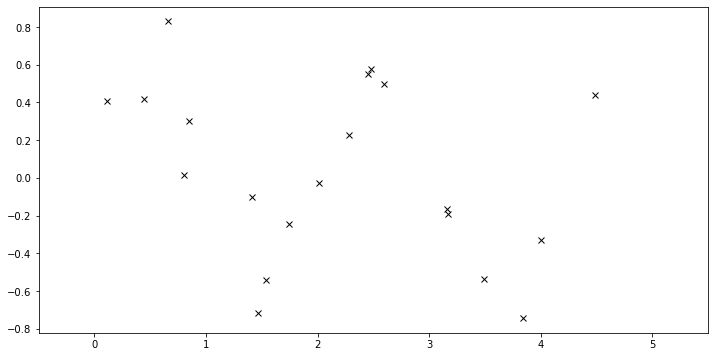

In [3]:
N = 20
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
y = 0.5 * torch.sin(3 * X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))

plot(plot_observed_data=True)  # let's plot the observed data

## Define model

First we define a RBF kernel, specifying the values of the two hyperparameters `variance` and `lengthscale`. Then we construct a `GPRegression` object. Here we feed in another hyperparameter, `noise`, that corresponds to $\epsilon$ above.

In [4]:
kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(6.0), lengthscale=torch.tensor(0.05)
)
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.1))

Let's see what samples from this GP function prior look like. Note that this is _before_ we've conditioned on the data. The shape these functions take&mdash;their smoothness, their vertical scale, etc.&mdash;is controlled by the GP kernel.

(-8.0, 8.0)

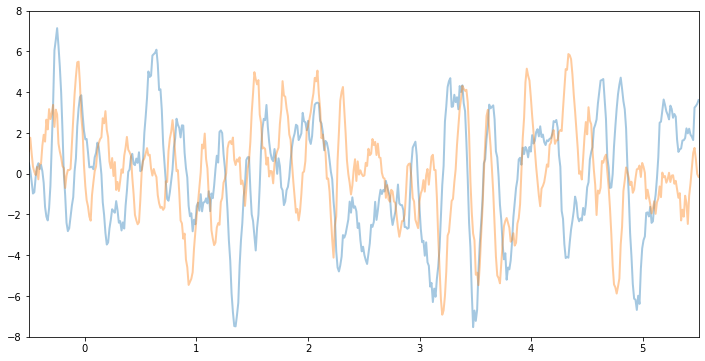

In [5]:
plot(model=gpr, kernel=kernel, n_prior_samples=2)
plt.ylim((-8, 8))

For example, if we keep the same `variance` and `noise` and increase the `lengthscale`, we will see smoother function samples.

(-8.0, 8.0)

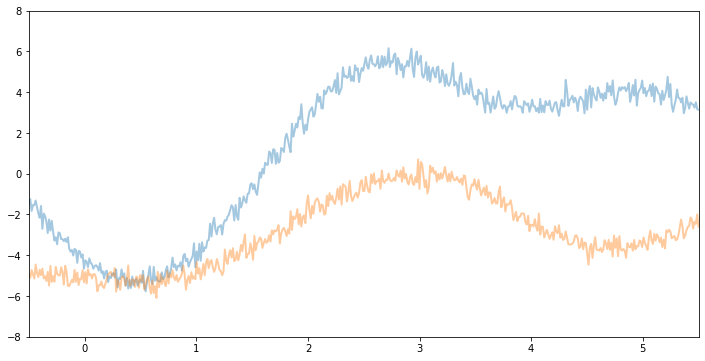

In [6]:
kernel2 = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(6.0), lengthscale=torch.tensor(1)
)
gpr2 = gp.models.GPRegression(X, y, kernel2, noise=torch.tensor(0.1))
plot(model=gpr2, kernel=kernel2, n_prior_samples=2)
plt.ylim((-8, 8))

Now, if we make `variance` and `noise` smaller we will see function samples with smaller vertical amplitude.

(-8.0, 8.0)

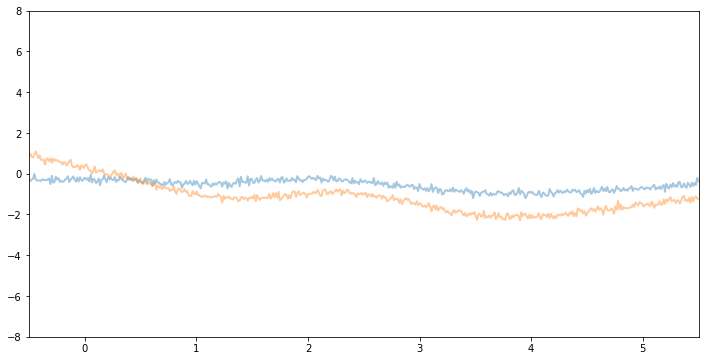

In [7]:
kernel3 = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(1)
)
gpr3 = gp.models.GPRegression(X, y, kernel3, noise=torch.tensor(0.01))
plot(model=gpr3, kernel=kernel3, n_prior_samples=2)
plt.ylim((-8, 8))

## Inference

In the above we set the kernel hyperparameters by hand. If we want to learn the hyperparameters from the data, we need to do inference. In the simplest (conjugate) case we do gradient ascent on the log marginal likelihood. In `pyro.contrib.gp`, we can use any [PyTorch optimizer](https://pytorch.org/docs/stable/optim.html) to optimize parameters of a model. In addition, we need a loss function which takes inputs are the pair model and guide and returns an ELBO loss (see [SVI Part I](svi_part_i.ipynb) tutorial).

In [8]:
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variances = []
lengthscales = []
noises = []
num_steps = 2000 if not smoke_test else 2
for i in range(num_steps):
    variances.append(gpr.kernel.variance.item())
    noises.append(gpr.noise.item())
    lengthscales.append(gpr.kernel.lengthscale.item())
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

Text(0, 0.5, 'Loss')

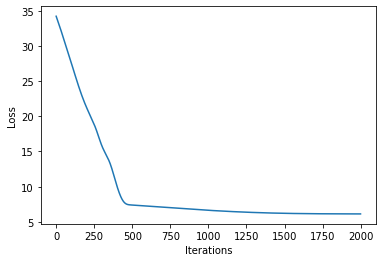

In [9]:
# let's plot the loss curve after 2000 steps of training
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")

Let's see if we're learned anything reasonable:

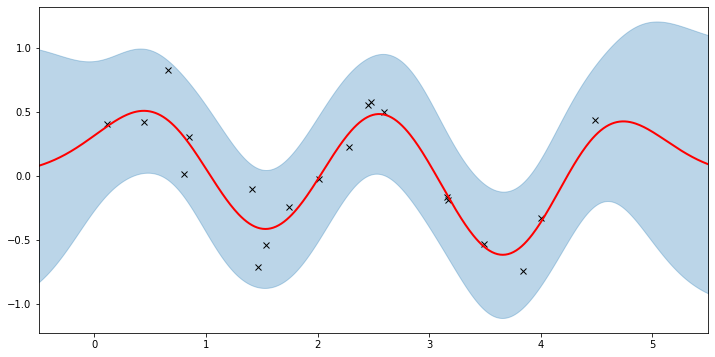

In [10]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

Here the thick red curve is the mean prediction and the blue band represents the 2-sigma uncertainty around the mean. It seems we learned reasonable kernel hyperparameters, as both the mean and uncertainty give a reasonable fit to the data. (Note that learning could have easily gone wrong if we e.g. chose too large of a learning rate or chose bad initital hyperparameters.)

Note that the kernel is only well-defined if `variance` and `lengthscale` are positive. Under the hood Pyro is using PyTorch constraints (see [docs](http://pytorch.org/docs/master/distributions.html#module-torch.distributions.constraints)) to ensure that hyperparameters are constrained to the appropriate domains. Let's see the constrained values we've learned.

In [11]:
gpr.kernel.variance.item()

0.21701902151107788

In [12]:
gpr.kernel.lengthscale.item()

0.5134539008140564

In [13]:
gpr.noise.item()

0.04248061776161194

The period of the sinusoid that generated the data is $T = 2\pi/3 \approx 2.09$ so learning a lengthscale that's approximiately equal to a quarter period makes sense. Let us now try to animate and see how our model improves over the training iterations.

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))


def update(iteration):
    pyro.clear_param_store()
    ax.cla()
    kernel_iter = gp.kernels.RBF(
        input_dim=1,
        variance=torch.tensor(variances[iteration]),
        lengthscale=torch.tensor(lengthscales[iteration]),
    )
    gpr_iter = gp.models.GPRegression(
        X, y, kernel_iter, noise=torch.tensor(noises[iteration])
    )
    plot(model=gpr_iter, plot_observed_data=True, plot_predictions=True, ax=ax)
    ax.set_title(f"Iteration: {iteration}, Loss: {losses[iteration]:0.2f}")


anim = FuncAnimation(fig, update, frames=np.arange(0, num_steps, 30), interval=100)
plt.close()

anim.save("../source/_static/img/gpr-fit.gif", fps=60)

![](../source/_static/img/gpr-fit.gif)

### Fit the model using MAP

We need to define priors for the hyperparameters.

Text(0, 0.5, 'Loss')

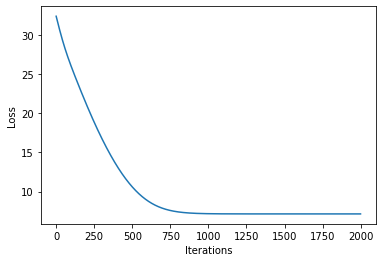

In [15]:
# Define the same model as before.
pyro.clear_param_store()
kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(5.0), lengthscale=torch.tensor(10.0)
)
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1.0))

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000 if not smoke_test else 2
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")

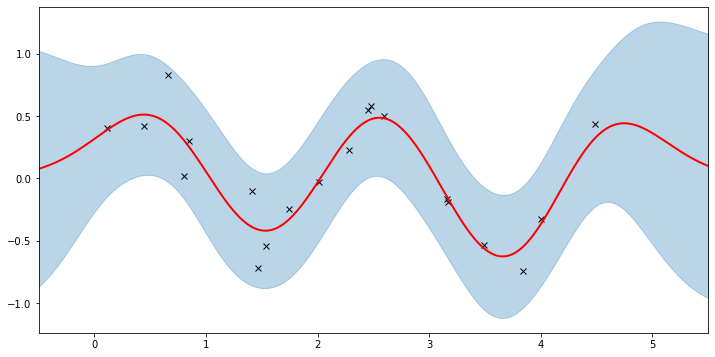

In [16]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

Let's inspect the hyperparameters we've learned:

In [17]:
# tell gpr that we want to get samples from guides
gpr.set_mode("guide")
print("variance = {}".format(gpr.kernel.variance))
print("lengthscale = {}".format(gpr.kernel.lengthscale))
print("noise = {}".format(gpr.noise))

variance = 0.24472779035568237
lengthscale = 0.5217776894569397
noise = 0.04222222790122032


Note that the MAP values are different from the MLE values due to the prior.

## Sparse GPs

For large datasets computing the log marginal likelihood is costly due to the expensive matrix operations involved (e.g. see Section 2.2 of [1]). A variety of so-called 'sparse' variational methods have been developed to make GPs viable for larger datasets. This is a big area of research and we won't be going into all the details. Instead we quickly show how we can use `SparseGPRegression` in `pyro.contrib.gp` to make use of these methods.

First, we generate more data.

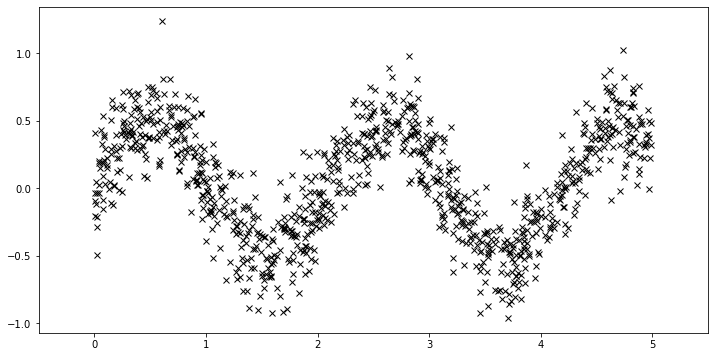

In [18]:
N = 1000
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
y = 0.5 * torch.sin(3 * X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))
plot(plot_observed_data=True)

Using the sparse GP is very similar to using the basic GP used above. We just need to add an extra parameter $X_u$ (the inducing points). Let us initialize the inducing points uniformly. During the course of learning, we will also optimize the locations of these inducing points.

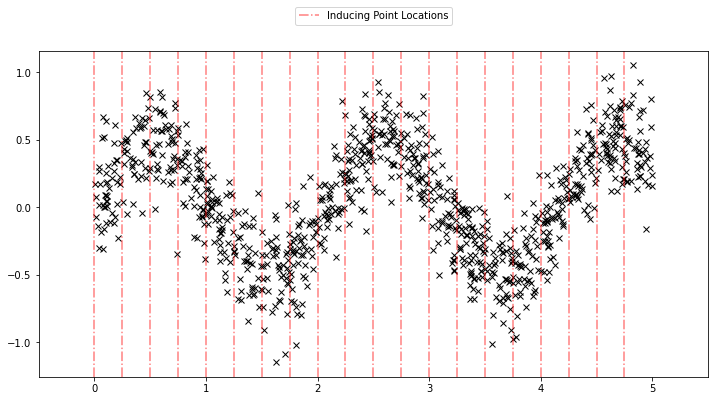

In [19]:
N = 1000
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
y = 0.5 * torch.sin(3 * X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))
plot(plot_observed_data=True)

# initialize the inducing inputs
Xu = torch.arange(20.0) / 4.0


def plot_inducing_points(Xu, ax=None):
    for xu in Xu:
        g = ax.axvline(xu, color="red", linestyle="-.", alpha=0.5)
    ax.legend(
        handles=[g],
        labels=["Inducing Point Locations"],
        bbox_to_anchor=(0.5, 1.15),
        loc="upper center",
    )


plot_inducing_points(Xu, plt.gca())

In [20]:
# initialize the kernel and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
# we increase the jitter for better numerical stability
sgpr = gp.models.SparseGPRegression(X, y, kernel, Xu=Xu, jitter=1.0e-5)

# the way we setup inference is similar to above
optimizer = torch.optim.Adam(sgpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
locations = []
variances = []
lengthscales = []
noises = []
num_steps = 2000 if not smoke_test else 2
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(sgpr.model, sgpr.guide)
    locations.append(sgpr.Xu.data.numpy().copy())
    variances.append(sgpr.kernel.variance.item())
    noises.append(sgpr.noise.item())
    lengthscales.append(sgpr.kernel.lengthscale.item())
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

Text(0, 0.5, 'Loss')

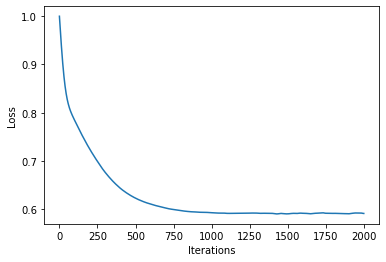

In [21]:
plt.plot(lengthscales)
plt.xlabel("Iterations")
plt.ylabel("Loss")

Now, we can plot the predictions from the learnt model along with the optimized inducing points locations.

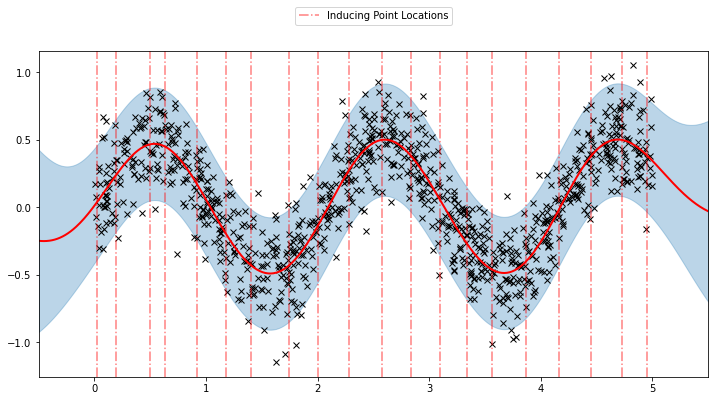

In [22]:
plot(model=sgpr, plot_observed_data=True, plot_predictions=True)
plot_inducing_points(sgpr.Xu.data.numpy(), plt.gca())

We can see that the model learns a reasonable fit to the data.  We can also see how that the inducing point locations are fairly different from our initialization. We can also view the model learning process via an animation below.

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))


def update(iteration):
    pyro.clear_param_store()
    ax.cla()
    kernel_iter = gp.kernels.RBF(
        input_dim=1,
        variance=torch.tensor(variances[iteration]),
        lengthscale=torch.tensor(lengthscales[iteration]),
    )
    sgpr_iter = gp.models.SparseGPRegression(
        X,
        y,
        kernel_iter,
        Xu=torch.tensor(locations[iteration]),
        noise=torch.tensor(noises[iteration]),
        jitter=1.0e-5,
    )
    plot(model=sgpr_iter, plot_observed_data=True, plot_predictions=True, ax=ax)
    plot_inducing_points(sgpr_iter.Xu.data.numpy(), ax=ax)
    ax.set_title(f"Iteration: {iteration}, Loss: {losses[iteration]:0.2f}")
    fig.tight_layout()


anim = FuncAnimation(fig, update, frames=np.arange(0, num_steps, 30), interval=100)
plt.close()
anim.save("../source/_static/img/svgpr-fit.gif", fps=60)

![](../source/_static/img/svgpr-fit.gif)

There are three different sparse approximations that are currently implemented in Pyro:

- "DTC" (Deterministic Training Conditional)

- "FITC" (Fully Independent Training Conditional)

- "VFE" (Variational Free Energy) 

By default, `SparseGPRegression` will use "VFE" as the inference method. We can use other methods by passing a different `approx` flag to `SparseGPRegression`.

## More Sparse GPs

Both `GPRegression` and `SparseGPRegression` above are limited to Gaussian likelihoods. We can use other likelihoods with GPs&mdash;for example, we can use the Bernoulli likelihood for classification problems&mdash;but the inference problem becomes more difficult. In this section, we show how to use the `VariationalSparseGP` module, which can handle non-Gaussian likelihoods. So we can compare to what we've done above, we're still going to use a Gaussian likelihood. The point is that the inference that's being done under the hood can support other likelihoods.

### Gaussian Likelihood

Text(0, 0.5, 'Loss')

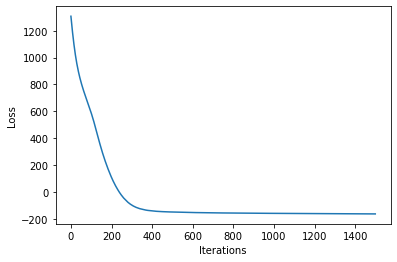

In [24]:
# initialize the inducing inputs
Xu = torch.arange(10.0) / 2.0

# initialize the kernel, likelihood, and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
likelihood = gp.likelihoods.Gaussian()
# turn on "whiten" flag for more stable optimization
vsgp = gp.models.VariationalSparseGP(
    X, y, kernel, Xu=Xu, likelihood=likelihood, whiten=True
)

# instead of defining our own training loop, we will
# use the built-in support provided by the GP module
num_steps = 1500 if not smoke_test else 2
losses = gp.util.train(vsgp, num_steps=num_steps)
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")

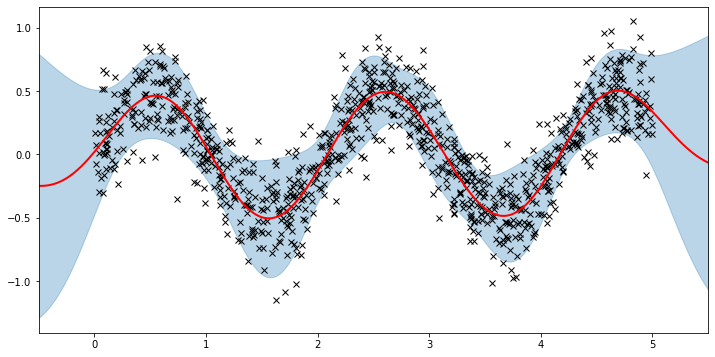

In [25]:
plot(model=vsgp, plot_observed_data=True, plot_predictions=True)

## GP Classification

We will now briefly discuss GP classification for multi-class classification. The two main changes needed to the model specification (in comparison to GP regression) are:

$$p(y\mid f)=\mathrm{Softmax}(f)$$

or $$y \sim \mathrm{Categorical(Softmax(f))}$$


We will be using the Iris dataset in our example. We will encode the three classes as numbers 0 for setosa, 1 for versicolor, and 2 for virginica. Also, to keep the example simple, we will be considering only two input features (petal length and petal width).

In [26]:
df = sns.load_dataset("iris")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [27]:
# only take petal length and petal width
X = torch.from_numpy(
    df[df.columns[2:4]].values.astype("float32"),
)
df["species"] = df["species"].astype("category")
# encode the species as 0, 1, 2
y = torch.from_numpy(df["species"].cat.codes.values.copy())

Text(0, 0.5, 'Feature 2 (Petal width)')

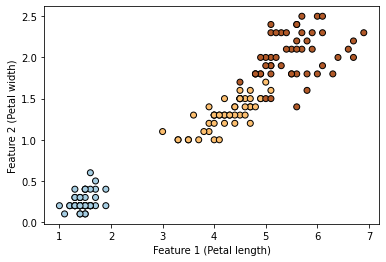

In [28]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors=(0, 0, 0))
plt.xlabel("Feature 1 (Petal length)")
plt.ylabel("Feature 2 (Petal width)")

In [29]:
kernel = gp.kernels.RBF(input_dim=2)
pyro.clear_param_store()
likelihood = gp.likelihoods.MultiClass(num_classes=3)
# Important -- we need to add latent_shape argument here to the number of classes we have in the data
model = gp.models.VariationalGP(
    X,
    y,
    kernel,
    likelihood=likelihood,
    whiten=True,
    jitter=1e-03,
    latent_shape=torch.Size([3]),
)
num_steps = 1000
loss = gp.util.train(model, num_steps=num_steps)

Text(0, 0.5, 'Loss')

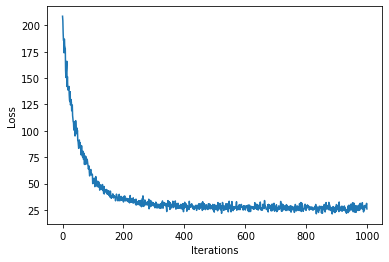

In [30]:
plt.plot(loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")

In [31]:
mean, var = model(X)
y_hat = model.likelihood(mean, var)

print(f"Accuracy: {(y_hat==y).sum()*100/(len(y)) :0.2f}%")

Accuracy: 96.00%


We can also calculate the confusion matrix.

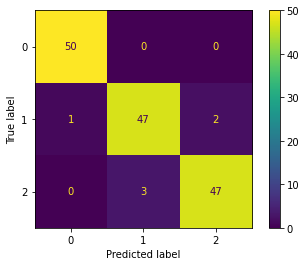

In [32]:
cm = confusion_matrix(y, y_hat, labels=[0, 1, 2])
ConfusionMatrixDisplay(cm).plot()

As before, let us plot our predictions over a 2d grid.

In [33]:
xs = torch.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, steps=100)
ys = torch.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, steps=100)
# In newer version we should uncomment the following line to replace the next 3 lines
# xx, yy = torch.meshgrid(xs, ys, indexing="xy")

xx, yy = torch.meshgrid(xs, ys)
xx = xx.t()
yy = yy.t()


with torch.no_grad():
    mean, var = model(torch.vstack((xx.ravel(), yy.ravel())).t())
    Z = model.likelihood(mean, var)

/Users/nipun/miniforge3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1643987874214/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [34]:
def plot_pred_2d(arr, xx, yy, contour=False, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = ax.imshow(
        arr,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect="equal",
        origin="lower",
        cmap=plt.cm.PuOr_r,
    )
    if contour:
        contours = ax.contour(
            xx,
            yy,
            torch.sigmoid(mean).reshape(xx.shape),
            levels=[0.5],
            linewidths=2,
            colors=["k"],
        )

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    ax.get_figure().colorbar(image, cax=cax)
    if title:
        ax.set_title(title)

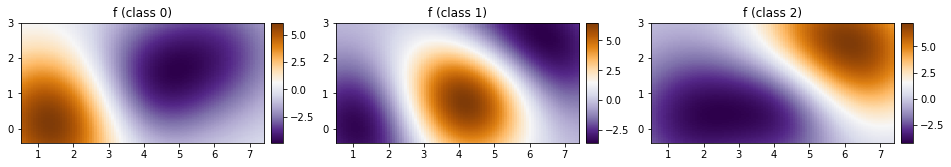

In [35]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))
for cl in [0, 1, 2]:
    plot_pred_2d(
        mean[cl, :].reshape(xx.shape), xx, yy, ax=ax[cl], title=f"f (class {cl})"
    )

In [36]:
p_class = torch.nn.functional.softmax(mean, dim=0)

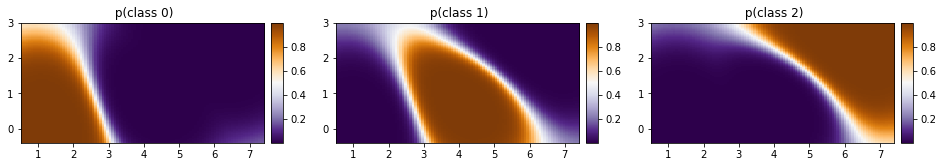

In [37]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))
for cl in [0, 1, 2]:
    plot_pred_2d(
        p_class[cl, :].reshape(xx.shape), xx, yy, ax=ax[cl], title=f" p(class {cl})"
    )

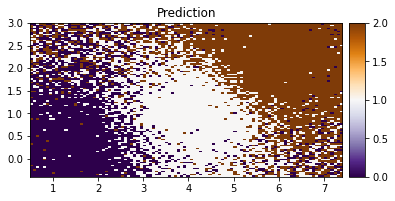

In [38]:
plot_pred_2d(Z.reshape(xx.shape), xx, yy, title="Prediction")

We can see our model doing a good job in classifying the IRIS data based on the two features. 

## Combining Kernels

We now look into combining different kernels. We will create a simple data set containing a linear trend and some periodicity.

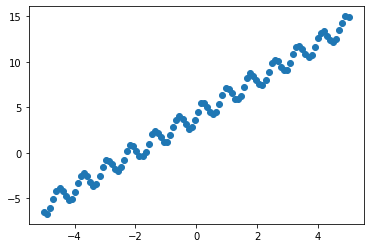

In [39]:
X = torch.linspace(-5, 5, 100)
y = torch.sin(X*8) + 2*X + 4 + 0.2*torch.rand_like(X)
plt.scatter(X, y)

We can clearly see a trend in the data. Let us use a combined kernel as follows:

`Linear + RBF * Periodic`

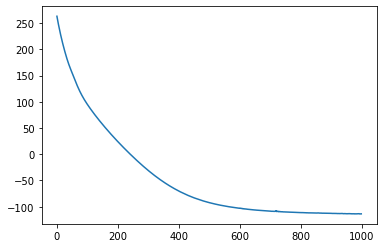

In [40]:
pyro.clear_param_store()
linear = gp.kernels.Linear(input_dim=1, )
periodic  = gp.kernels.Periodic(input_dim=1, period=torch.tensor(0.5), lengthscale=torch.tensor(4.))
rbf = gp.kernels.RBF(input_dim=1, lengthscale=torch.tensor(0.5), variance=torch.tensor(0.5))
k1 = gp.kernels.Product(kern0=rbf, kern1=periodic)

k = gp.kernels.Sum(linear, k1)
model = gp.models.GPRegression(
    X=X,
    y=y,
    kernel=k,
    jitter=2e-3,
)

loss = gp.util.train(model)
plt.plot(loss)

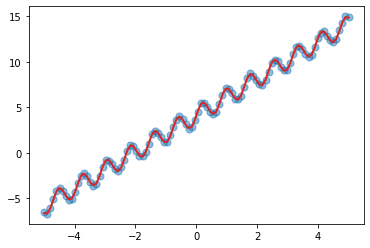

In [41]:
plt.scatter(X, y, s = 50, alpha=0.5)

with torch.no_grad():
    mean, var = model(X)
plt.plot(X, mean, color='C3', lw=2)

We can see that our combination of kernel does a fairly good job in learning the inherent trend and periodicity in the data. 

That's all there is to it. For more details on the `pyro.contrib.gp` module see the [docs](http://docs.pyro.ai/en/dev/contrib/gp.html). For an example on binary classification see [here](https://prog-ml.github.io/notebooks/gaussian_processes/pyro-binary-classification.html), for an example on deep kernel learning see [here](https://prog-ml.github.io/notebooks/gaussian_processes/pyro-deep-gp.html), and for an advanced example for GP classification using deep kernel learning see [here](https://github.com/pyro-ppl/pyro/blob/dev/examples/contrib/gp/sv-dkl.py).

## Reference

[1] `Deep Gaussian processes and variational propagation of uncertainty`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Andreas Damianou

[2] `A unifying framework for sparse Gaussian process approximation using power expectation propagation`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Thang D. Bui, Josiah Yan, and Richard E. Turner

[3] `Scalable variational Gaussian process classification`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
James Hensman, Alexander G. de G. Matthews, and Zoubin Ghahramani

[4] `Gaussian Processes for Machine Learning`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Carl E. Rasmussen, and Christopher K. I. Williams

[5] `A Unifying View of Sparse Approximate Gaussian Process Regression`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Joaquin Quinonero-Candela, and Carl E. Rasmussen